In [1]:
import pandas as pd 

import numpy as np 
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandas.api import types

from linearmodels import PanelOLS
import causallib as cl
from causallib.estimation import IPW

from sklearn.linear_model import LogisticRegression, LinearRegression

from econml.dml import DML
from econml.dr import LinearDRLearner # Example of a direct DR learner

In [2]:
data = pd.read_csv("src/did_training_productivity.csv", index_col = 0)
data["interaction"] = data["post"]*data["treat_group"]

### Inverse probability weighting

In [4]:
covariates = data[['female', 'mothers_educ', 'technical', 'immigrant',
                   'base_productivity', 'tenure', 'prev_performance',
                   'team_size', 'manager_exp']].copy()

In [5]:
ordinal_map = {'<HS': 0, 'HS': 1, 'College': 2, 'Graduate': 3}
covariates["mothers_educ"] = covariates["mothers_educ"].map(ordinal_map)

In [6]:
learner = LogisticRegression(penalty="l1", C=0.01, max_iter=500, solver='liblinear')
ipw = IPW(learner)
ipw.fit(covariates, data["treat_group"])

IPW(_doc_link_module=sklearn, _doc_link_template=https://scikit-learn.org/1.6/modules/generated/{estimator_module}.{estimator_name}.html, _doc_link_url_param_generator=None, clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(C=0.01, max_iter=500, penalty='l1', solver='liblinear'))

In [7]:
weights = ipw.compute_weights(covariates, data["treat_group"])
data['ipw_weight'] = weights

In [8]:
reg_data = data.reset_index().copy()
reg_data = reg_data.set_index(["worker_id", "period"])

y = reg_data["productivity"].copy()
X = reg_data["interaction"].copy()

In [9]:
weighted_model = PanelOLS(y,X, entity_effects=True, time_effects=True, weights=data['ipw_weight']).fit(cov_type= "clustered", cluster_entity = True)

In [10]:
weighted_model

Dep. Variable:,productivity,R-squared:,0.2191
Estimator:,PanelOLS,R-squared (Between):,0.0802
No. Observations:,48000,R-squared (Within):,0.4272
Date:,"Fri, Apr 18 2025",R-squared (Overall):,0.0856
Time:,19:12:09,Log-likelihood,-1.812e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,1.29e+04
Entities:,2000,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(1,45976)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,1.018e+04


### Regression adjustment

In [103]:
df_delta_prod = data.reset_index().copy()

In [104]:
pre_treatment_avg = df_delta_prod[df_delta_prod["period"] < 13].groupby("worker_id")["productivity"].mean()
post_treatment_avg = df_delta_prod[df_delta_prod["period"] >= 13].groupby("worker_id")["productivity"].mean()

delta_prod_per_worker = post_treatment_avg - pre_treatment_avg

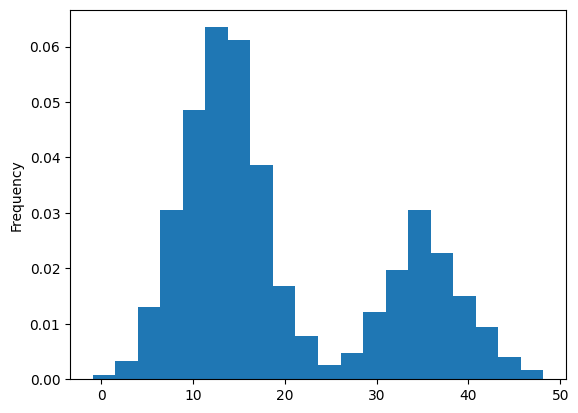

In [105]:
delta_prod_per_worker.plot.hist(bins  = 20, density = True);

In [106]:
worker_prod_dic = delta_prod_per_worker.to_dict()
df_delta_prod["delta_prod"] = df_delta_prod["worker_id"].map(worker_prod_dic)   

In [107]:
covariates_name = ['female', 'mothers_educ', 'technical', 'immigrant',
                   'base_productivity', 'tenure', 'prev_performance',
                   'team_size', 'manager_exp']

ordinal_map = {'<HS': 0, 'HS': 1, 'College': 2, 'Graduate': 3}

In [109]:
df_delta_prod["mothers_educ"] = df_delta_prod["mothers_educ"].map(ordinal_map)

In [111]:
df_delta_control = df_delta_prod.loc[df_delta_prod["treat_group"] == 0,]
df_delta_control = df_delta_control.set_index(["worker_id", "period"])

y_delta_control = df_delta_control["delta_prod"]
X_delta_control = sm.add_constant(df_delta_control[covariates_name])

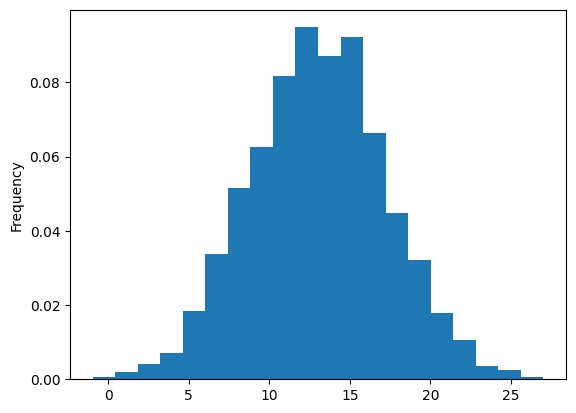

In [113]:
y_delta_control.plot.hist(bins = 20, density = True);

In [115]:
y_delta_control.shape

(33624,)

In [119]:
regression_adjustment_step1 = PanelOLS(y_delta_control,X_delta_control, entity_effects=False, time_effects=False, drop_absorbed= False).fit(cov_type= "clustered", cluster_entity = True)

In [120]:
regression_adjustment_step1

Dep. Variable:,delta_prod,R-squared:,0.0030
Estimator:,PanelOLS,R-squared (Between):,0.0032
No. Observations:,33624,R-squared (Within):,0.0000
Date:,"Fri, Apr 18 2025",R-squared (Overall):,0.0030
Time:,19:58:43,Log-likelihood,-9.604e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,11.305
Entities:,1401,P-value,0.0000
Avg Obs:,24.000,Distribution:,"F(9,33614)"
Min Obs:,24.000,,
Max Obs:,24.000,F-statistic (robust):,5.3882


In [121]:
df_delta_treated = df_delta_prod.loc[df_delta_prod["treat_group"] == 1,]
df_delta_treated = df_delta_treated.set_index(["worker_id", "period"])

y_delta_treated = df_delta_treated["delta_prod"]
X_delta_treated = sm.add_constant(df_delta_treated[covariates_name])

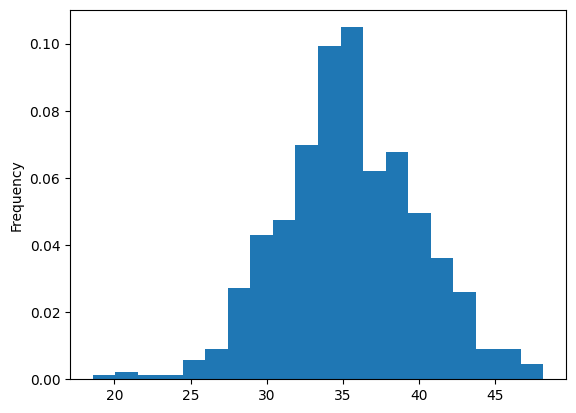

In [125]:
y_delta_treated.plot.hist(bins = 20, density =True);

In [126]:
predicted_delta_y = regression_adjustment_step1.predict(X_delta_treated)

<Axes: ylabel='Frequency'>

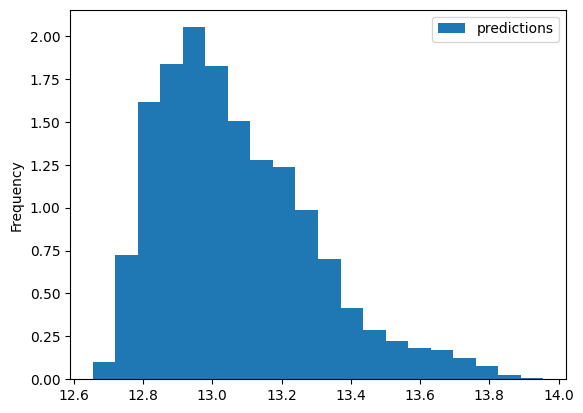

In [129]:
predicted_delta_y.plot.hist(bins = 20, density = True)

In [130]:
y_delta_treated.mean()-predicted_delta_y.mean()

predictions    22.399959
dtype: float64

### Doubly Robust Estimator

In [38]:
Y = data['productivity'].values  # Outcome
T = data['treat_group'].values    # Treatment (binary)
X = covariates_regdata.values  # Features/Covariates
W = None

In [39]:
est = LinearDRLearner()
est.fit(y, T, X=X, W=W)
point = est.effect(X, T1=1)
lb, ub = est.effect_interval(X, T1=1, alpha=0.05)
# Get CATE for all treatments
point = est.const_marginal_effect(X)
lb, ub = est.const_marginal_effect_interval(X, alpha=0.05)

c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Saverio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

In [43]:
overall_ate = point.mean()
print("\nAverage Marginal Effect(s):")
print(point)
print(f"\nOverall Average Treatment Effect: {overall_ate}")


Average Marginal Effect(s):
[[  1.0362054 ]
 [-10.45214394]
 [  1.22547425]
 ...
 [ 23.99668178]
 [ 23.69631963]
 [ 23.91367685]]

Overall Average Treatment Effect: 13.588682120819927


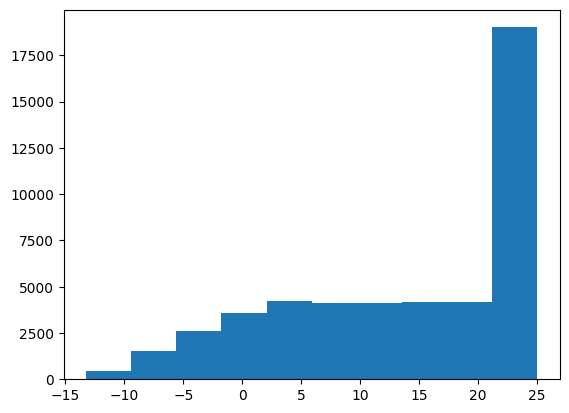

In [46]:
plt.hist(point);